In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials

In [138]:
py_filepath = "/home/INT/losada.c/Documents/data/test/lip/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"

### Load file

In [139]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

### Select relevant trials

In [140]:
# Selec trials in a block
n_block = 2
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
print('Number of clusters: %d'%len(sp_py['sp_samples'][0]))


Number of trials in block 2: 104
Number of correct trials in block 2: 80
Number of clusters: 16


In [141]:
len(sp_py['sp_samples'][0])

16

### Select trials by target code

In [142]:
# Define target codes 
target_codes= {
    # code: [ML axis], [plot axis]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}

In [143]:
# create dict with the trials that have each code
trials_idx = {}
for i_key,key in enumerate(target_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, sp_py['code_numbers'][trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    trials_idx[key]={'code_idx':code_idx,'trials_idx':trials}

## Plot rasters for each neuron for each target

#### define variables

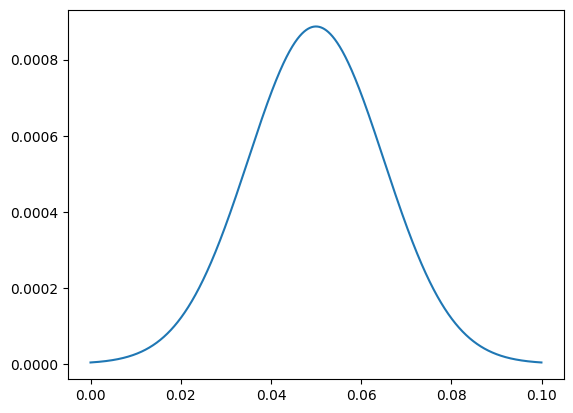

In [144]:
target_on = 37
# kernel parameters
fs = 30000
w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms
# define kernel for the convolution
kernel = signal.gaussian(M=w_size*fs,std=w*fs)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/fs,kernel)

#### Plot all trials with the same code for all neurons 

##### Split in stimulus presentation delay and saccade
Compute:
* visual pref / visual unpref -> target_on(37) - target_off(38)
* delay pref / delay unpref -> target_off(38) - fix_spot_off(36)
* saccade pref / saccade unpref -> fix_spot_off(10) - correct_response(40)

In [145]:
events = {
    'target_on': 37,
    'target_off': 38,
    'fix_spot_off': 36,
    'correct_response': 40,
    'start_trial':9,
    'end_trial':18
}

/tmp/ipykernel_4939/3727039520.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))


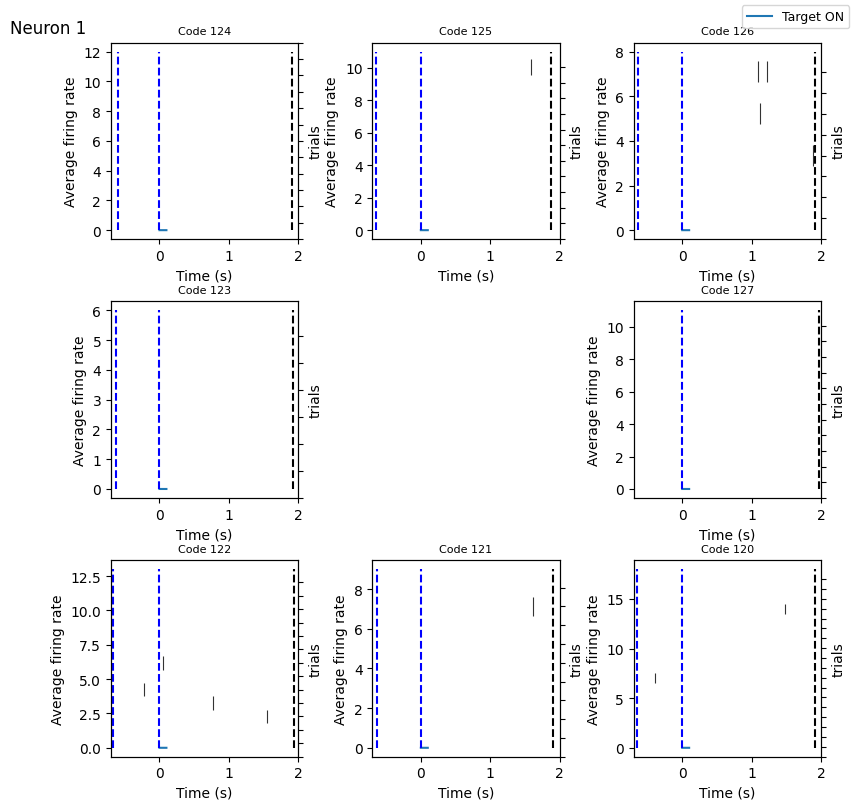

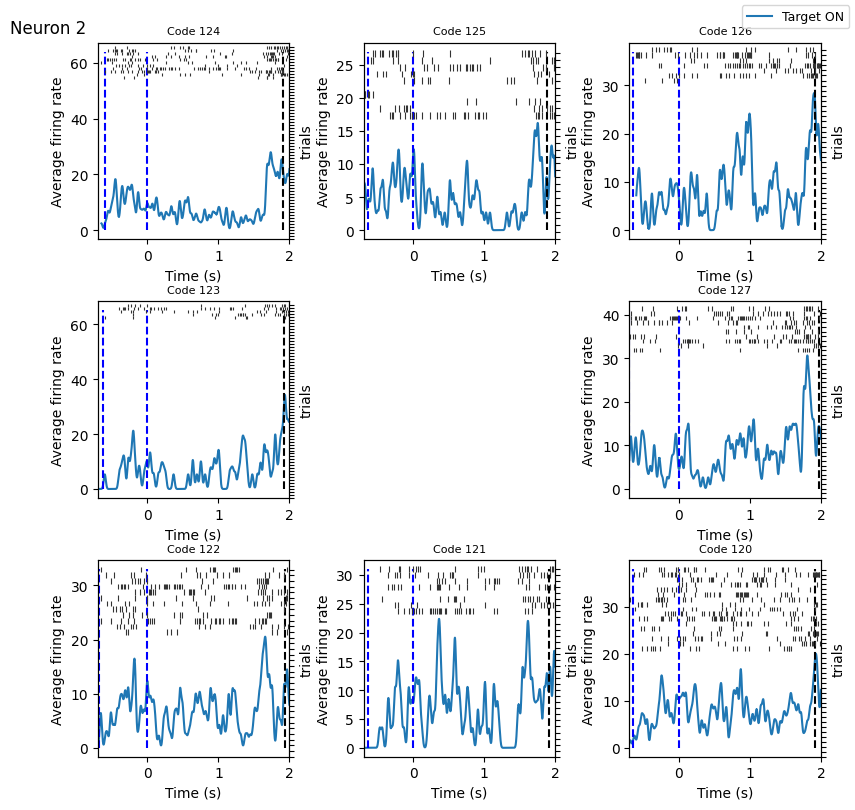

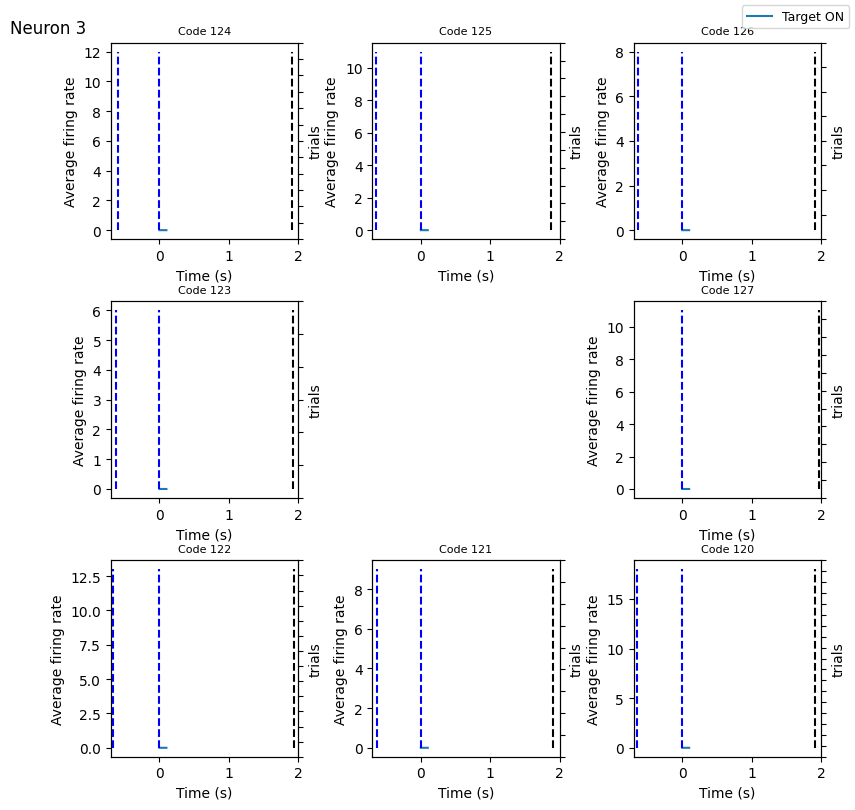

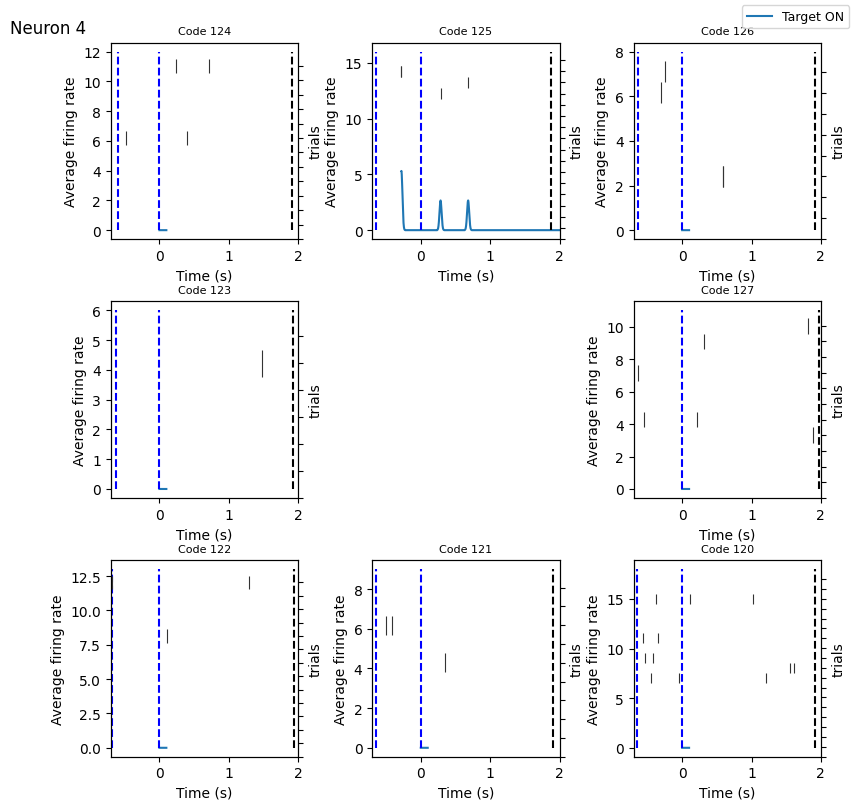

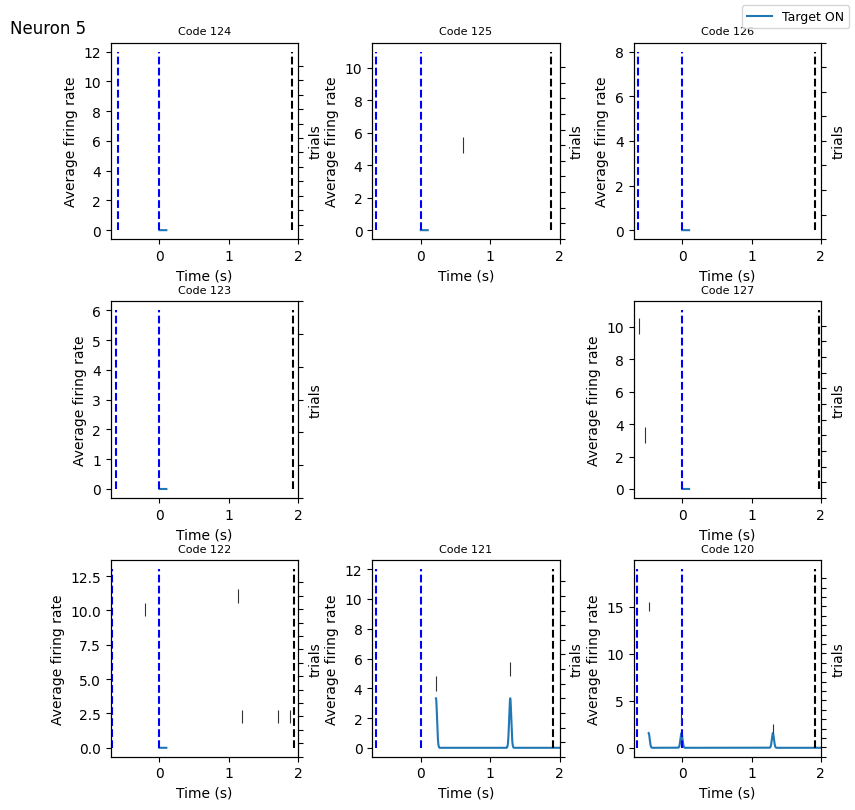

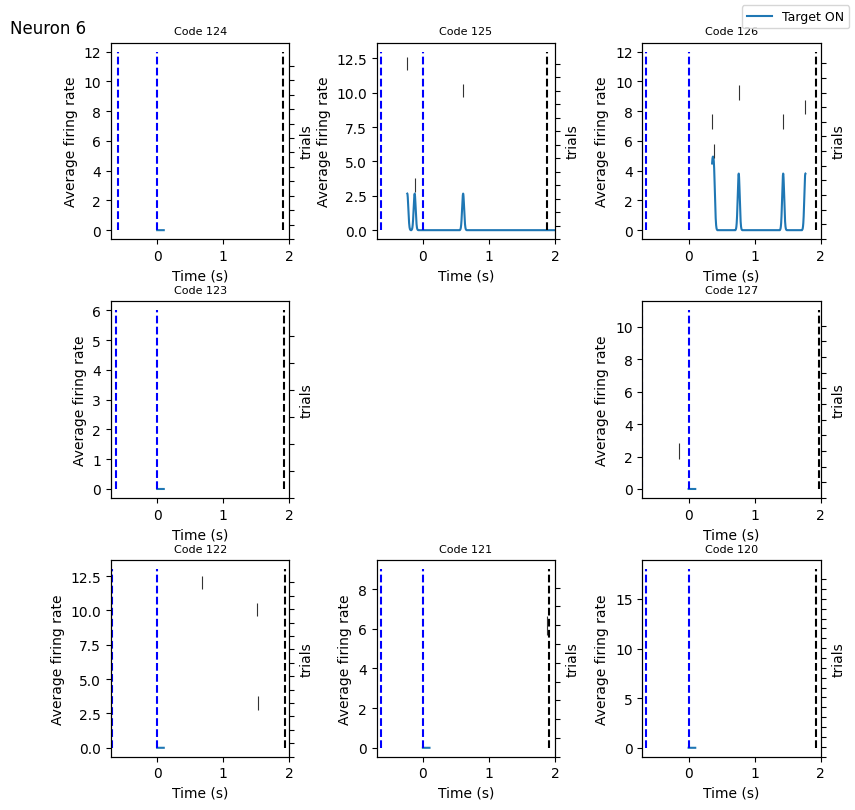

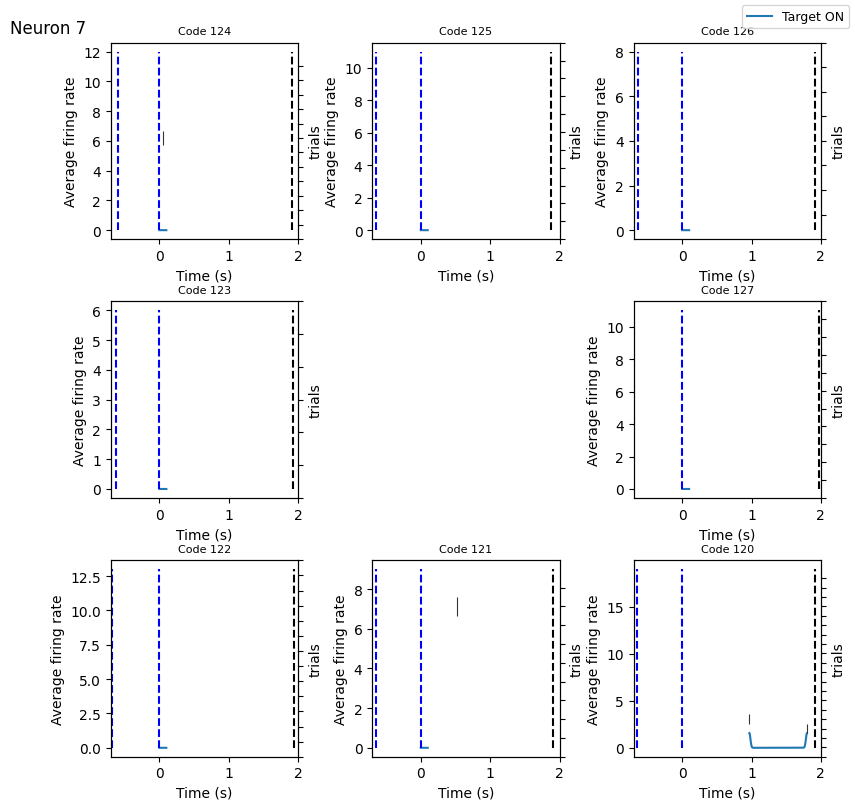

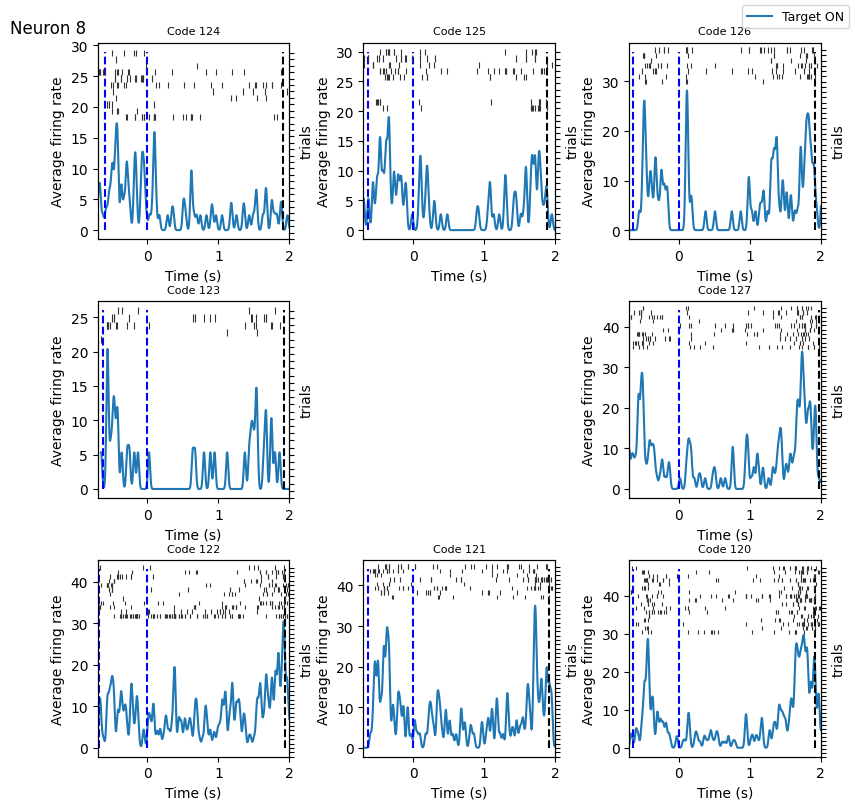

In [146]:
fs = 30000
# plots x lim
x_lim_max=2
x_lim_min = -0.7
# select only individual neurons
neurons = np.where(sp_py['clustersgroup']=='good')[0]
mean_fr:Dict[str,list] = defaultdict(list)
for i,neuron in enumerate(neurons):
    
    fig,_ = plt.subplots(figsize=(8, 8),sharex=True,sharey=True)
    for code in target_codes.keys():
        target_trials_idx = trials_idx[code]["trials_idx"] # select trials with the same stimulus
        events_timestamps = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
        neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, events_timestamps[:,0]) 
        axis= target_codes[code][1]
        ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))
        if len(neuron_trials[0]) != 0:
            # Compute trial average fr
            trial_average_sp,sorted_sp_neuron = firing_rate.trial_average_fr(neuron_trials)
        else:
            trial_average_sp=[0]*len(kernel)
            sorted_sp_neuron=[0]*len(kernel)
        conv = np.convolve(trial_average_sp,kernel,mode='same')*fs
        # compute mean of conv between events
        mean_idx_events = np.floor(((events_timestamps.T-events_timestamps.T[0]).T).mean(axis=0))
        conv_visual = conv[mean_idx_events[0]:mean_idx_events[1]]
        conv_delay = conv[mean_idx_events[1]:mean_idx_events[2]]
        conv_saccade = conv[mean_idx_events[2]:mean_idx_events[-3]]
        # add values to dict
        events_concat = np.concatenate((conv_visual,conv_delay,conv_saccade))
        mean_fr['mean_fr'] += events_concat.tolist()
        mean_fr['event'] += ['visual']*len(conv_visual)
        mean_fr['event'] += ['delay']*len(conv_delay)
        mean_fr['event'] += ['saccade']*len(conv_saccade)
        mean_fr['neuron'] += [i+1]*len(events_concat)
        mean_fr['code'] += [code] *len(events_concat)
        # plot
        fig=firing_rate.plot_raster_fr(trial_average_sp,sorted_sp_neuron,conv,fs,neuron_trials,code,ax,fig,i,x_lim_max,x_lim_min,events=mean_idx_events)

    fig.legend(['Target ON'], fontsize=9)
    plt.show()

In [147]:
mean_fr=pd.DataFrame(mean_fr)

In [149]:
"""124/120
125/121
126/122
127/123"""

'124/120\n125/121\n126/122\n127/123'

In [150]:
neurons

array([ 1,  2,  4,  9, 12, 13, 14, 15])

In [151]:
t_test:Dict[str,list] = defaultdict(list)
for i_n, neuron in enumerate(neurons):
    for event in ['visual','delay','saccade']:
        for i,sides in enumerate([['124','120'],['125','121'],['126','122'],['127','123']]):
            a=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==sides[0])]
            b=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==sides[1])]
            p=stats.ttest_ind(a['mean_fr'].values, b['mean_fr'].values, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=.4)
            t_test['sides']+=[sides]
            t_test['neuron']+=[i_n+1]
            t_test['event']+=[event]
            t_test['p']+=[p[1]]

In [152]:
t_test=pd.DataFrame(t_test)

In [153]:
t_test

,sides,neuron,event,p
0,"[124, 120]",1,visual,NaN
1,"[125, 121]",1,visual,NaN
2,"[126, 122]",1,visual,NaN
3,"[127, 123]",1,visual,NaN
4,"[124, 120]",1,delay,NaN
...,...,...,...,...
91,"[127, 123]",8,delay,0.000000e+00
92,"[124, 120]",8,saccade,2.412532e-40
93,"[125, 121]",8,saccade,0.000000e+00
94,"[126, 122]",8,saccade,0.000000e+00


In [155]:
t_test[t_test['neuron']==8]

,sides,neuron,event,p
84,"[124, 120]",8,visual,0.000000e+00
85,"[125, 121]",8,visual,1.255065e-02
86,"[126, 122]",8,visual,2.920289e-192
87,"[127, 123]",8,visual,1.655977e-121
88,"[124, 120]",8,delay,4.619829e-126
89,"[125, 121]",8,delay,4.984085e-17
90,"[126, 122]",8,delay,1.765853e-160
91,"[127, 123]",8,delay,0.000000e+00
92,"[124, 120]",8,saccade,2.412532e-40
93,"[125, 121]",8,saccade,0.000000e+00


In [167]:
a=mean_fr[(mean_fr['neuron']==2) & (mean_fr['event']=='saccade')& (mean_fr['code']=='124')]
b=mean_fr[(mean_fr['neuron']==2) & (mean_fr['event']=='saccade')& (mean_fr['code']=='120')]
p=stats.ttest_ind(a['mean_fr'].values, b['mean_fr'].values[:17552], axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=.4)


In [163]:
a['mean_fr'].values[:17552]

array([6.77410673, 6.76478113, 6.75546364, ..., 2.82534107, 2.82277005,
       2.82019712])

In [165]:
a['mean_fr'].shape

(17552,)

In [166]:
b.shape

(18043, 4)

In [168]:
p

Ttest_indResult(statistic=-38.91841772635145, pvalue=3.3785744412265586e-300)